In [ ]:
from setup_libs import *

: 

# [LightGBM](https://github.com/Microsoft/LightGBM)

LightGBM (Light Gradient Boosted Machine) — open source библиотека бустинга, от Microsoft. 

### Что позволяет LightGBM работать быстрее обычного бустинга?

Важный и затратный по времени шаг — построение дерева решений, требующий O(объём данных * кол-во признаков (feature)) времени.<br>
LightGBM использует алгоритмы **GOSS** и **EFB** для его ускорения. Первый уменьшает размер выборки, второй — количество фич.

### GOSS — Gradient-based One Side Sampling
Метод уменьшения выборки с учётом градиента. Чем больше градиент <...>, тем больше ошибка при обучении, следовательно <...> с большими градиентами сильнее влияют на обучение. Идея GOSS состоит в отбрасывании случайных объектов с небольшими градиентами и перебалансировке оставшейся выборки.

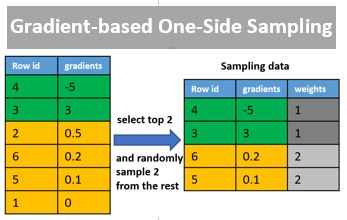

In [3]:
Image('images/goss.jpg')

$X$ - выборка<br>
$a (0 < a < len(X))$ — количество сохраняемых объектов с большими градиентами<br>
$b (0 < b \leq len(X) - a )$ — количество переносящихся в новую выборку объектов с небольшими градиентами

#### Алгоритм:
* Данная выборка сортируется по убыванию градиентов
* Первые $a$ объектов сохраняются в новую выборку
* $b$ случайных объектов из оставшихся $(len(X) - a)$ сохраняются в новую выборку с весами \frac{len(X) - a}{и}

### EFB — Exclusive Feature Bundling
Количество фич можно значительно сократить, если среди них встречается много взаимоисключающих, не принимающих одновременно нулевые значения признаков. EFB объединяет такие фичи в `bundles`.

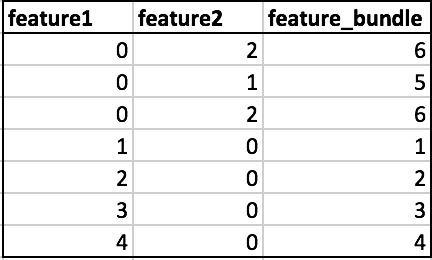

In [7]:
Image('images/efb.png')

Конфликт — количество различных перекрывающихся ненулевых значений.

Алгоритм:
* Заводится массив `bundles` и пороговое значение количества конфликтов `threshold`
* Подсчитываются конфликты между всеми фичами
* Фичи сортируются в порядке убывания количества ненулевых значений
* В цикле по отсортированным фичам:
    - если при добавлении фичи в последний `bundle` конфликт не превышает порога, фича добавляется
    - иначе — в массив кладётся новый `bundle`, куда добавляется фича
Объединение фич внутри каждого `bundle` в одну:
* Рассчитывается такое смещение для каждой из фич, чтобы была биекция между суммой значений со смещениями и первоначальными комбинациями значений фич
* Смещения прибавляются к фичам
* Значения по каждому объекту суммируются

Задача нахождения оптимального объединения фич NP-полная, алгоритм EFB был выбран в результате экспериментов.

### Принцип построения дерева решений LightGBM
Многие алгоритмы строят дерево выборов "в ширину", по уровням (`level-wise growth`), тогда как LightGBM — в глубину до листьев (`leaf-wise growth`). Для предотвращения построения ... При таком подходе `One-Hot Encoding` преобразование категориальных фич (замена одной фичи на множество со значениями 1 и 0) может привести к сильному росту дерева в глубину,

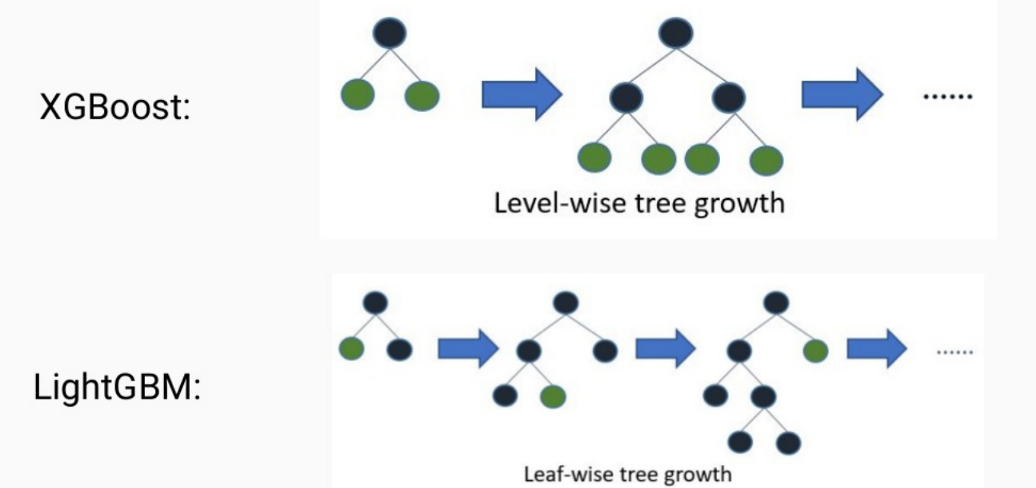

In [5]:
Image('images/Lwise_growth.png')

[Статья](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf)